<h2>Palantir analysis notebook</h2>

<h3>Table of contents</h3>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data Processing</a>
<br/>
<a href='#palantir'>Running Palantir</a>
<br/>
<a href='#palantir2'>Visualizing Palantir results</a>
<br/>
<a href='#trends'>Gene expression trends</a>
<br/>
<a href='#clustering'>Clustering of cells and gene expression trends</a>

<a id="intro"></a><h2> Introduction </h2>

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination. 

See <a href="https://www.nature.com/articles/s41587-019-0068-4">our manuscript</a> for more details.

## Imports

In [1]:
import palantir
import scanpy as sc
import numpy as np
import os

# Plotting 
import matplotlib
import matplotlib.pyplot as plt

# Inline plotting
%matplotlib inline

# Reset random seed
np.random.seed(5)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


<a id="data"></a><h2> Loading data </h2>

We recommend the use of <a href="https://scanpy-tutorials.readthedocs.io/en/latest/index.html">scanpy</a> <a href="https://anndata.readthedocs.io/en/latest/">Anndata</a> objects as the preferred mode of loading and filtering data. 

A sample RNA-seq csv data is available at `<palantir directory>/data/marrow_sample_scseq_counts.h5ad`. This sample data will be used to demonstrate the utilization and capabilities of the Palantir package. This dataset contains ~4k cells and ~16k genes and is pre-filtered. Check the <a href="https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html">scanpy introductory tutorial</a> for filtering cells and genes. 



In [2]:
# Load sample data
palantir_dir = os.path.expanduser('~/repositories/palantir/')
ad = sc.read(palantir_dir + 'data/marrow_sample_scseq_counts.h5ad')
ad

AnnData object with n_obs × n_vars = 4142 × 16106

<b>NOTE</b>: Counts are assumed to the normalized. If you have already normalized the data, skip past the `Normalization` section

## Data processing

### Normalization

Normalize the data for molecule count distribution using the `scanpy` interface

In [3]:
sc.pp.normalize_per_cell(ad)

/usr/local/anaconda3/envs/python3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a `pseudocount` of 0.1 instead of 1.

In [4]:
palantir.preprocess.log_transform(ad)

### Highly variable gene selection

Highly variable gene selection can also be performed using the `scanpy` interface

In [5]:
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor='cell_ranger')

### PCA

PCA is the first step in data processing for Palantir. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data. 

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.

In [6]:
# Note in the manuscript, we did not use highly variable genes and hence use_hvg is set to False. 
# We recommend setting use_hvg to True for other datasets
pca_projections, _ = palantir.utils.run_pca(ad, use_hvg=False)

In [7]:
pca_projections.shape

(4142, 300)

### Diffusion maps

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [8]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [9]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

### Visualization

In the manuscript, we used tSNE projection using diffusion components to visualize the data. We now recommend the use of force-directed layouts for visualization of trajectories. Force-directed layouts can be computed by the same adaptive kernel used for determining diffusion maps. `tSNE` on diffusion components can still be computed using the function `tsne = palantir.utils.run_tsne(ms_data)`.

Our package, <a href="https://github.com/dpeerlab/Harmony">Harmony</a> provides an interface for computing force directed layouts.

In [10]:
import harmony
fdl = harmony.plot.force_directed_layout(dm_res['kernel'], ad.obs_names)

100%|██████████| 500/500 [00:21<00:00, 22.78it/s]

BarnesHut Approximation  took  9.30  seconds
Repulsion forces  took  11.11  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.62  seconds
AdjustSpeedAndApplyForces step  took  0.39  seconds


tSNE or FDL results can be visualized by the `plot_tsne` function.

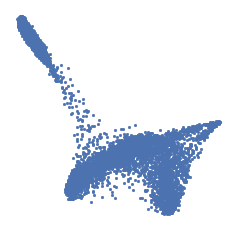

In [11]:
fig, ax = palantir.plot.plot_tsne(fdl)

For consistency with the previous tutorial and the manuscript, we will use the pre-computed tSNE for this dataset. 

In [12]:
import pandas as pd
tsne = pd.read_pickle(palantir_dir + 'data/sample_tsne.p')

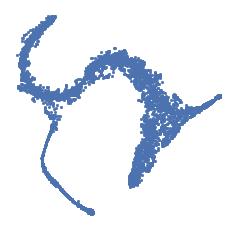

In [13]:
fig, ax = palantir.plot.plot_tsne(tsne)

### MAGIC imputation 

<a href="https://github.com/pkathail/magic">MAGIC</a> is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [14]:
imp_df = palantir.utils.run_magic_imputation(ad, dm_res)

Gene expression can be visualized on tSNE maps using the `plot_gene_expression` function. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of HSC gene `CD34`, myeloid gene `MPO` and erythroid precursor gene `GATA1` and  dendritic cell gene `IRF8`. 

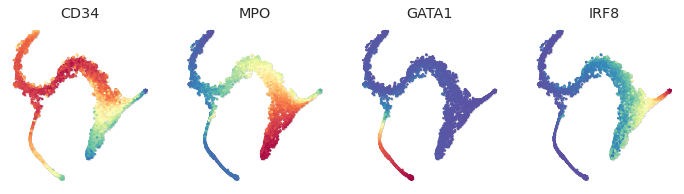

In [15]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['CD34', 'MPO', 'GATA1', 'IRF8'])

The same functions can be used to plot gene expression on force directed layouts.

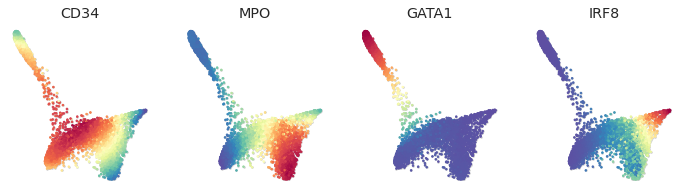

In [16]:
palantir.plot.plot_gene_expression(imp_df, fdl, ['CD34', 'MPO', 'GATA1', 'IRF8'])

### Diffusion maps visualization

The computed diffusion components can be visualized with the following snippet.

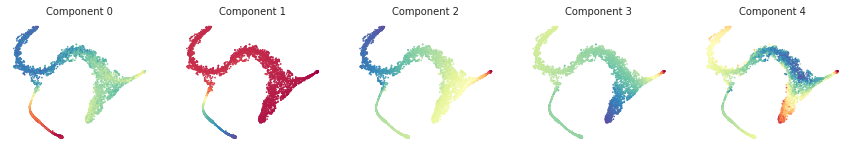

In [17]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

<a id="palantir"></a><h2> Running Palantir </h2>

Palantir can be run by specifying an approxiate early cell. 

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the ```terminal_states``` parameter

The start cell for this dataset was chosen based on high expression of CD34.

In [18]:
terminal_states = pd.Series(['DC', 'Mono', 'Ery'], 
                           index=['Run5_131097901611291', 'Run5_134936662236454', 'Run4_200562869397916'])

In [19]:
start_cell = 'Run5_164698952452459'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.002189020315806071 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.10048529704411825 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir generates the following results 
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the <i>differentiation potential</i> of each cell computed as the entropy of the multinomial terminal state probabilities

The terminal states in this dataset are renamed to reflect the known biology below

In [20]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

<a id="palantir2"></a><h2> Visualizing Palantir results </h2>

Palantir results can be visualized on the tSNE map using the `plot_palantir_results` function

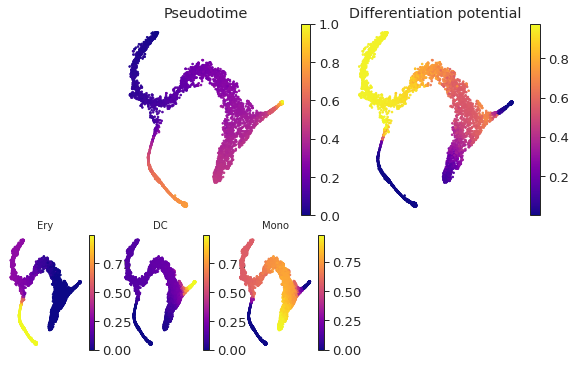

In [21]:
palantir.plot.plot_palantir_results(pr_res, tsne)

Terminal state probability distributions of individual cells can be visualized using the `plot_terminal_state_probs` function

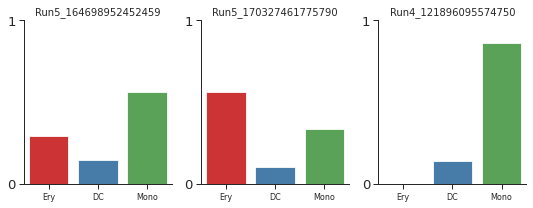

In [22]:
cells = ['Run5_164698952452459', 'Run5_170327461775790', 'Run4_121896095574750', ]
palantir.plot.plot_terminal_state_probs(pr_res, cells) 

The cells can be highlighted on the tSNE map using the `highlight_cells_on_tsne` function

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

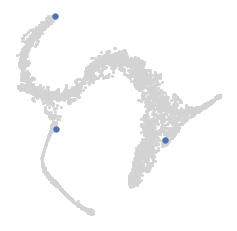

In [23]:
palantir.plot.highlight_cells_on_tsne(tsne, cells)

<a id='trends'></a><h2> Gene expression trends </h2>

Palantir uses <a href="https://cran.r-project.org/web/packages/gam/">Generalized Additive Models (GAMs) </a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [24]:
genes = ['CD34', 'MPO', 'GATA1', 'IRF8']
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

Ery
Time for processing Ery: 0.0638781984647115 minutes
DC
Time for processing DC: 0.03965953191121419 minutes
Mono
Time for processing Mono: 0.037533096472422284 minutes


The determined trends can be visualized with the `plot_gene_trends` function. A separate panel is generated  for each gene

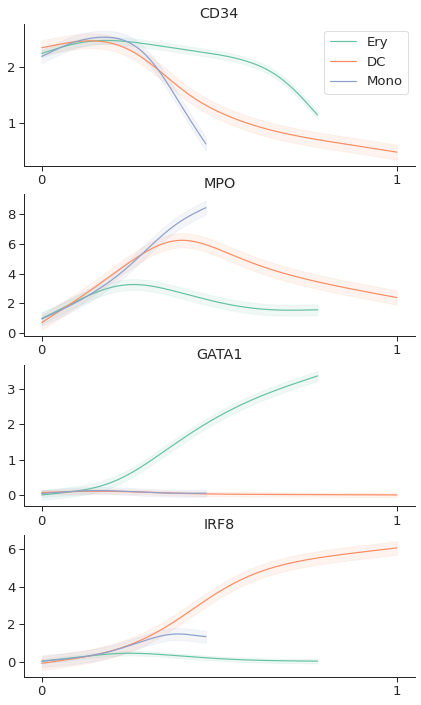

In [25]:
palantir.plot.plot_gene_trends(gene_trends)

Alternatively, the trends can be visualized on a heatmap using

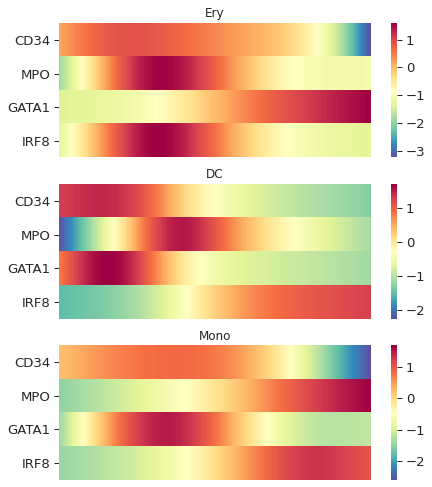

In [26]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

<a id="clustering"></a><h3> Clustering </h3>

Cells can be clustered and visualized using <a href="https://github.com/dpeerlab/PhenoGraph">Phenograph</a> with the following snippet.

In [27]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0404338836669922 seconds
Jaccard graph constructed in 1.9258291721343994 seconds
Wrote graph to binary file in 0.9615311622619629 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.678405
After 8 runs, maximum modularity is Q = 0.67979
Louvain completed 28 runs in 2.2500929832458496 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 6.844569206237793 seconds


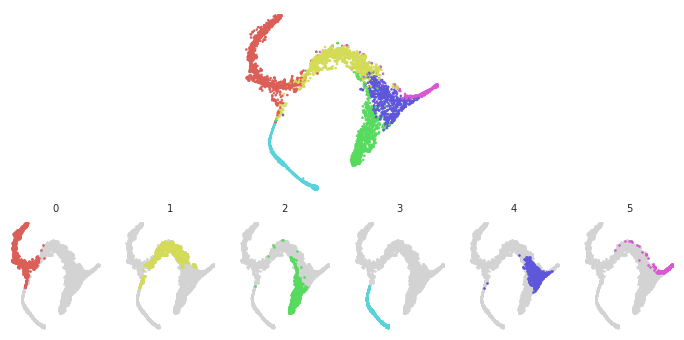

In [28]:
palantir.plot.plot_cell_clusters(tsne, clusters )

Similary, gene expression trends can be clustered and visualized using the following snippet. As an example, the first 1000 genes along the erythroid genes are clustered

In [29]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['Ery'])

Ery
Time for processing Ery: 0.3008660475413005 minutes


In [30]:
# Cluster
trends = gene_trends['Ery']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.09891080856323242 seconds
Jaccard graph constructed in 2.829073905944824 seconds
Wrote graph to binary file in 0.4603431224822998 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.605564
Louvain completed 21 runs in 0.7905471324920654 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.922311782836914 seconds


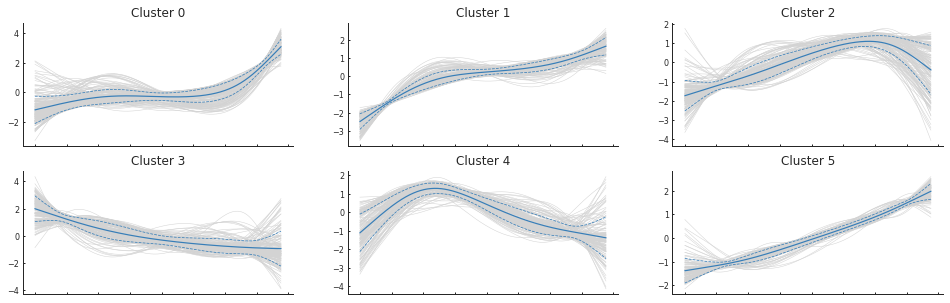

In [31]:
palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)